In [1]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
dls = ImageDataLoaders.from_name_re(path, get_image_files(path/'images'), pat='(.+)_\d+.jpg', item_tfms=Resize(460), batch_tfms=aug_transforms(size=224, min_scale=0.75), bs=128)
learn = cnn_learner(dls, models.resnet50, metrics=accuracy, cbs=[SaveModelCallback(), ShowGraphCallback()], opt_func=ranger)

/home/camaro/anaconda3/envs/gradio/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


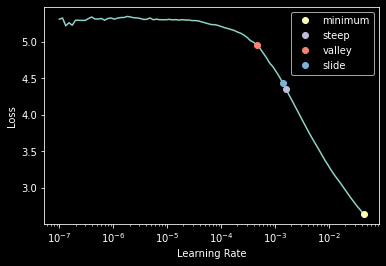

In [3]:
learn.freeze()
lrs = learn.lr_find(end_lr=1e-1,suggest_funcs=(minimum, steep, valley, slide))

epoch,train_loss,valid_loss,accuracy,time
0,1.857970,0.287825,0.901894,00:27
1,0.825620,0.209105,0.929635,00:27
2,0.479395,0.202690,0.930311,00:27
3,0.330174,0.193720,0.935724,00:27
4,0.236931,0.179199,0.944520,00:27


Better model found at epoch 0 with valid_loss value: 0.28782516717910767.


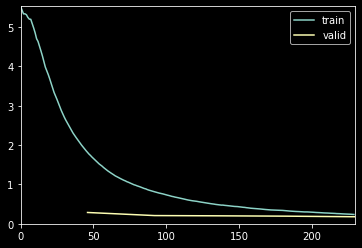

Better model found at epoch 1 with valid_loss value: 0.20910464227199554.
Better model found at epoch 2 with valid_loss value: 0.20268966257572174.
Better model found at epoch 3 with valid_loss value: 0.19371958076953888.
Better model found at epoch 4 with valid_loss value: 0.17919906973838806.


In [4]:
learn.fit_flat_cos(5, lrs.slide)

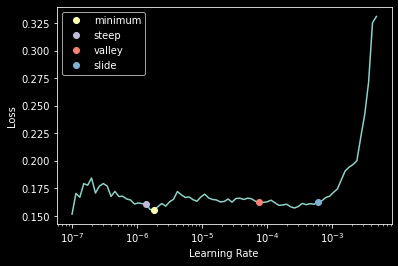

In [5]:
learn.unfreeze()
lrs = learn.lr_find(end_lr=1e-1,suggest_funcs=(minimum, steep, valley, slide))

epoch,train_loss,valid_loss,accuracy,time
0,0.167330,0.178793,0.941137,00:29
1,0.172421,0.179297,0.942490,00:29
2,0.171947,0.180934,0.943166,00:30
3,0.178377,0.177924,0.941813,00:30
4,0.177207,0.180480,0.940460,00:30


Better model found at epoch 0 with valid_loss value: 0.17879317700862885.


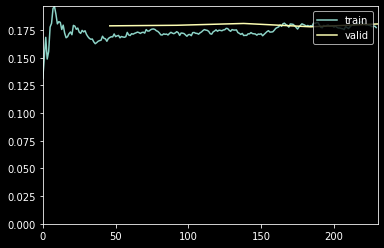

Better model found at epoch 3 with valid_loss value: 0.17792417109012604.


In [6]:
learn.fit_flat_cos(5, 1e-7)

In [ ]:
# learn.fine_tune(50)
learn.path = Path('.')
learn.export()

In [ ]:
from fastai.vision.all import *
learn = load_learner('export.pkl')

In [ ]:
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [ ]:
import os
for root, dirs, files in os.walk(r'sample_images/'):
    for filename in files:
        print(filename)

In [ ]:
import gradio as gr

title = "Pet Breed Classifier"
description = "A pet breed classifier trained on the Oxford Pets dataset"
interpretation='default'
# examples = ['siamese.jpg', 'kitten.jpg']
examples = ["sample_images/"+file for file in files] 
article="<p style='text-align: center'><a href='https://dicksonneoh.com' target='_blank'>Blog post</a></p>"
enable_queue=True

gr.Interface(fn=predict,inputs=gr.inputs.Image(shape=(512, 512)),outputs=gr.outputs.Label(num_top_classes=3),title=title,description=description,article=article,examples=examples,interpretation=interpretation,enable_queue=enable_queue).launch(share=True)
